100%|██████████| 10/10 [00:00<00:00, 54050.31it/s]


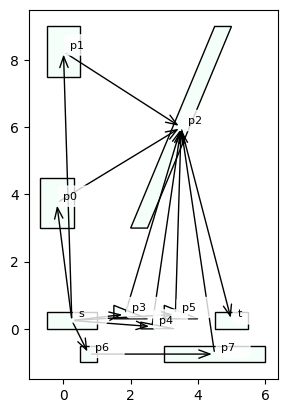

In [9]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np

from large_gcs.graph.cost_constraint_factory import create_2d_x_equality_edge_constraint, create_2d_y_equality_edge_constraint, create_l1norm_edge_cost
from large_gcs.graph.graph import DefaultGraphCostsConstraints, Edge, Graph

def create_polyhedral_hor_vert_b_graph() -> Graph:
    dim = 2
    # Convex sets
    box_vert = np.array([[0, 0], [1, 0], [1, 1.5], [0, 1.5]], dtype=np.float64)
    sets = (
        # source
        Polyhedron.from_vertices([[-0.5, 0], [1, 0], [1, 0.5], [-0.5, 0.5]]),
        # target
        Polyhedron.from_vertices([[4.5, 0], [5.5, 0], [5.5, 0.5], [4.5, 0.5]]),
        # intermediate sets
        Polyhedron.from_vertices(box_vert + np.array([-0.7, 3])),
        Polyhedron.from_vertices(box_vert + np.array([-0.5, 7.5])),
        # Diagonal set
        Polyhedron.from_vertices([[2, 3], [2.5, 3], [5, 9], [4.5, 9]]),
        # Cluster of 3
        Polyhedron.from_vertices([[1.5, 0.3], [2.5, 0.3], [1.5, 0.7]]),
        Polyhedron.from_vertices([[2.3, 0], [3.3, 0], [2.3, 0.2]]),
        Polyhedron.from_vertices([[3, 0.3], [4, 0.3], [3, 0.7]]),
        # Bottom row
        Polyhedron.from_vertices([[0.5, -1], [1, -1], [1, -0.5], [0.5, -0.5]]),
        Polyhedron.from_vertices([[3,-1], [6,-1], [6,-0.5], [3,-0.5]]),
    )

    # Vertex names
    vertex_names = ["s", "t"]
    vertex_names += [f"p{i}" for i in range(len(sets) - 2)]

    # Edge costs
    # edge_cost = create_l2norm_squared_edge_cost(dim)
    edge_cost = create_l1norm_edge_cost(dim)
    default_costs_constraints = DefaultGraphCostsConstraints(edge_costs=[edge_cost])
    # Add convex sets to graph
    G = Graph(default_costs_constraints)
    G.add_vertices_from_sets(sets, names=vertex_names)
    G.set_source("s")
    G.set_target("t")

    # Edges
    vert_edges = {
        "s": ("p0", "p1", "p6"),
        "p2": ("t",),
        "p3": ("p2",),
        "p4": ("p2",),
        "p5": ("p2",),
        "p7": ("p2",),
    }
    hor_edges = {
        "s": ("p3", "p4", "p5",),
        "p0": ("p2",),
        "p1": ("p2",),
        "p6": ("p7",),
    }

    def add_edges(edges, constraints):
        for u, vs in edges.items():
            for v in vs:
                # print(f"Adding edge {u} -> {v}")
                G.add_edge(Edge(u, v, constraints=constraints))

    vert_constraint = [create_2d_x_equality_edge_constraint()]
    hor_constraint = [create_2d_y_equality_edge_constraint()]
    add_edges(vert_edges, vert_constraint)
    add_edges(hor_edges, hor_constraint)
    return G

G = create_polyhedral_hor_vert_b_graph()
G.plot_sets()
G.plot_edges()
G.plot_set_labels()


In [2]:
def plot_sol(sol):
    G.plot_sets()
    G.plot_path(sol.ambient_path)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=false and preprocessing=false and no rounding.


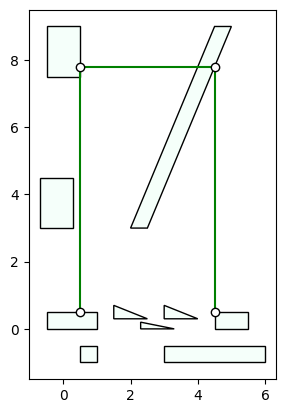

In [3]:
sol = G.solve_shortest_path()
plot_sol(sol)

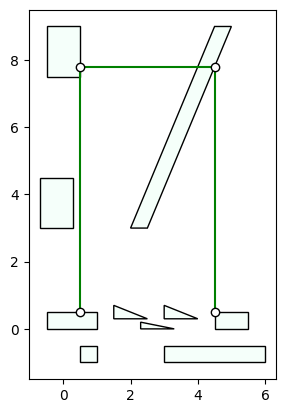

In [5]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.algorithms.search_algorithm import AlgVisParams
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.domination_checkers.reaches_cheaper_sampling import ReachesCheaperSampling
from large_gcs.graph.cost_constraint_factory import l1_norm_shortcut_edge_cost_factory

cost_estimator = ShortcutEdgeCE(graph=G,
                                shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
                                )
alg_vis_params = AlgVisParams()
domination_checker = ReachesCheaperSampling(graph=G, num_samples_per_vertex=10)
alg = GcsAstarReachability(graph=G,
                           cost_estimator=cost_estimator,
                           domination_checker=domination_checker,
                           vis_params=alg_vis_params,
                           )
sol = alg.run()
plot_sol(sol)


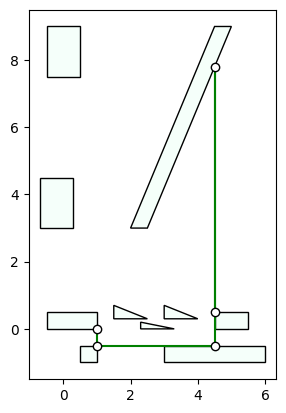

In [7]:
from large_gcs.domination_checkers.reaches_new_sampling import ReachesNewSampling


cost_estimator = ShortcutEdgeCE(graph=G,
                                shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
                                )
alg_vis_params = AlgVisParams()
domination_checker = ReachesNewSampling(graph=G, num_samples_per_vertex=10)
alg = GcsAstarReachability(graph=G,
                           cost_estimator=cost_estimator,
                           domination_checker=domination_checker,
                           vis_params=alg_vis_params,
                           )
sol = alg.run()
plot_sol(sol)